### Set up spark context and SparkSession

In [ ]:
Loretta Gray 7.4 Random Forrest Regression Commented with visuals Hw6
'''
Random Forest:

Modeling Approach: Random Forest builds many decision trees in parallel (independently).
It then averages the predictions of all trees to get the final output.
Ensemble Method: Bagging (Bootstrap Aggregating) is used, where each tree is trained on
a random subset of data with replacement, and the final prediction is an average of the
individual trees' predictions.
Strength: Good for reducing variance and avoiding overfitting. It tends to be more robust
to noisy data.
'''

In [ ]:
'''
This code initializes a Spark session in PySpark, which is essential
for working with Spark's DataFrame and SQL functionalities. It begins
by importing the findspark module and initializing it to locate the
Spark installation. Then, it imports SparkSession from pyspark.sql
and creates a new Spark session with the application name "Python
Spark RandomForest Regression example" and a placeholder configuration
option. The getOrCreate() method ensures that an existing Spark session is used if available; otherwise, it creates a
new one
'''

import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark RandomForest Regression example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/10 22:08:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
'''
This code reads a CSV file named "Advertising.csv" into a PySpark
DataFrame, specifying that the first row contains headers and that
Spark should infer the data types of each column. The df.show(5, True)
command displays the first five rows of the DataFrame along with the full
content of each column. The df.printSchema() command outputs the schema
of the DataFrame, showing the column names and their respective data
types.
'''
df = spark.read.format('csv') \
    .options(header='true', inferschema='true') \
    .load("file:///Users/ellegreyllc/Desktop/Advertising.csv")

df.show(5, True)
df.printSchema()



+-----+-----+---------+-----+
|   TV|Radio|Newspaper|Sales|
+-----+-----+---------+-----+
|230.1| 37.8|     69.2| 22.1|
| 44.5| 39.3|     45.1| 10.4|
| 17.2| 45.9|     69.3|  9.3|
|151.5| 41.3|     58.5| 18.5|
|180.8| 10.8|     58.4| 12.9|
+-----+-----+---------+-----+
only showing top 5 rows

root
 |-- TV: double (nullable = true)
 |-- Radio: double (nullable = true)
 |-- Newspaper: double (nullable = true)
 |-- Sales: double (nullable = true)



In [ ]:
'''
The code df.describe().show() generates summary statistics for all numerical columns in the DataFrame.
It computes metrics like count, mean, standard deviation, minimum, and maximum values for each column.
The .describe() function returns a new DataFrame containing these statistics, and .show() displays the
results in a readable format. This helps in understanding the distribution and characteristics of the
dataset.
'''
df.describe().show()

25/02/10 22:08:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+------------------+
|summary|               TV|             Radio|         Newspaper|             Sales|
+-------+-----------------+------------------+------------------+------------------+
|  count|              200|               200|               200|               200|
|   mean|         147.0425|23.264000000000024|30.553999999999995|14.022500000000003|
| stddev|85.85423631490805|14.846809176168728| 21.77862083852283| 5.217456565710477|
|    min|              0.7|               0.0|               0.3|               1.6|
|    max|            296.4|              49.6|             114.0|              27.0|
+-------+-----------------+------------------+------------------+------------------+



### Convert the data to dense vector (features and label)

In [ ]:
'''
This code transforms the DataFrame into a format suitable for machine learning in PySpark. It uses the
Resilient Distributed Dataset (RDD) API to map each row, converting all but the last column into a
feature vector (Vectors.dense(r[:-1])) and treating the last column as the label (r[-1]). The
transformed data is then converted back into a DataFrame with two columns: 'features' (containing
the vectorized inputs) and 'label' (the target variable). Finally, transformed.show(5) displays
the first five rows.
'''
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
transformed=df.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
transformed.show(5)

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[230.1,37.8,69.2]| 22.1|
| [44.5,39.3,45.1]| 10.4|
| [17.2,45.9,69.3]|  9.3|
|[151.5,41.3,58.5]| 18.5|
|[180.8,10.8,58.4]| 12.9|
+-----------------+-----+
only showing top 5 rows



### Deal with the Categorical variables, even they are numeric, if a feature columns has no more than 4 distinct values, it will be considered categorical and will be indexed to improve training model.

In [ ]:
'''
This code uses VectorIndexer to automatically identify and index categorical features in the
'features' column, creating a new 'indexedFeatures' column. It then transforms the dataset to
prepare it for regression modeling. Finally, it displays the first five rows of the updated
DataFrame.
'''
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed)

data = featureIndexer.transform(transformed)
data.show(5,True)

+-----------------+-----+-----------------+
|         features|label|  indexedFeatures|
+-----------------+-----+-----------------+
|[230.1,37.8,69.2]| 22.1|[230.1,37.8,69.2]|
| [44.5,39.3,45.1]| 10.4| [44.5,39.3,45.1]|
| [17.2,45.9,69.3]|  9.3| [17.2,45.9,69.3]|
|[151.5,41.3,58.5]| 18.5|[151.5,41.3,58.5]|
|[180.8,10.8,58.4]| 12.9|[180.8,10.8,58.4]|
+-----------------+-----+-----------------+
only showing top 5 rows



In [ ]:
# Import LinearRegression class
'''
This code initializes a RandomForestRegressor model in PySpark, using the 'indexedFeatures' column
as input. It prepares the model for training, with optional parameters like the number of trees,
max depth, and random seed.
'''
from pyspark.ml.regression import RandomForestRegressor

# Define LinearRegression algorithm
rf = RandomForestRegressor(featuresCol="indexedFeatures") # featuresCol="indexedFeatures",numTrees=2, maxDepth=2, seed=42


### Split the data into training and test sets (40% held out for testing)

In [ ]:
'''
This code splits the dataset into training (60%) and testing (40%) subsets using randomSplit().
It then displays the first five rows of both trainingData and testData to verify the split.
'''
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(5)
testData.show(5)

+---------------+-----+---------------+
|       features|label|indexedFeatures|
+---------------+-----+---------------+
| [0.7,39.6,8.7]|  1.6| [0.7,39.6,8.7]|
| [4.1,11.6,5.7]|  3.2| [4.1,11.6,5.7]|
| [5.4,29.9,9.4]|  5.3| [5.4,29.9,9.4]|
|[7.3,28.1,41.4]|  5.5|[7.3,28.1,41.4]|
|[7.8,38.9,50.6]|  6.6|[7.8,38.9,50.6]|
+---------------+-----+---------------+
only showing top 5 rows

+----------------+-----+----------------+
|        features|label| indexedFeatures|
+----------------+-----+----------------+
|   [8.6,2.1,1.0]|  4.8|   [8.6,2.1,1.0]|
| [8.7,48.9,75.0]|  7.2| [8.7,48.9,75.0]|
|[11.7,36.9,45.2]|  7.3|[11.7,36.9,45.2]|
| [17.2,4.1,31.6]|  5.9| [17.2,4.1,31.6]|
|[17.2,45.9,69.3]|  9.3|[17.2,45.9,69.3]|
+----------------+-----+----------------+
only showing top 5 rows



### Fit RandomForest Regression Model

If you decide to use the indexedFeatures features, you need to add the parameter featuresCol="indexedFeatures".

Pipeline Architecture

In [ ]:
'''
This code creates a Pipeline with the RandomForestRegressor as the only stage and fits it to the
trainingData. The resulting model is trained on the training dataset.
'''
pipeline = Pipeline(stages=[rf])
model = pipeline.fit(trainingData)

### Make test predictions with testdata

In [ ]:
'''
This code uses the trained model to make predictions on the testData.
It then selects and displays the 'indexedFeatures', 'label', and 'prediction' columns for
the first five rows of the predicted data.
'''
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("indexedFeatures","label", "prediction").show(5)

+----------------+-----+------------------+
| indexedFeatures|label|        prediction|
+----------------+-----+------------------+
|   [8.6,2.1,1.0]|  4.8| 7.113780723905724|
| [8.7,48.9,75.0]|  7.2|13.367500000000001|
|[11.7,36.9,45.2]|  7.3| 8.645605158730158|
| [17.2,4.1,31.6]|  5.9|7.6031416256157645|
|[17.2,45.9,69.3]|  9.3|14.475833333333332|
+----------------+-----+------------------+
only showing top 5 rows



### Evaluation

In [ ]:
# Select (prediction, true label) and compute test error
'''
This code initializes a RegressionEvaluator to calculate the Root Mean Squared Error (RMSE) between
the actual 'label' and predicted 'prediction' values. It then evaluates the model's performance on
the test data and prints the RMSE.
'''

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 1.70729


In [ ]:
'''
This code initializes a RegressionEvaluator to calculate the R-squared (R2) value, which measures
how well the model's predictions match the actual labels. It then evaluates the model on the test
data and prints the R2 value.
'''
evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % evaluator.evaluate(predictions))

R Squared (R2) on test data = 0.877232


In [ ]:
'''
This code returns the type of the last stage in the Pipeline (which is the trained model,
RandomForestRegressor). It shows the class type of the model, confirming that it's a
RandomForestRegressor.
'

type(model.stages[-1])

pyspark.ml.regression.RandomForestRegressionModel

In [ ]:
'''This code retrieves the feature importances from the trained RandomForestRegressor model,
which indicates the relative importance of each feature in making predictions. The output is
typically a vector of values corresponding to each feature, with higher values indicating greater
importance.
'''
model.stages[-1].featureImportances

SparseVector(3, {0: 0.5556, 1: 0.3512, 2: 0.0932})

### Feature importances, there are 3 features, index 0 is the root had highest feature importance value, 0.4736, .... This means, advertising on TV is most important feature

### Show all decision trees in the random forest

In [ ]:
'''
This code retrieves the individual decision trees from the trained RandomForestRegressor model.
It returns a list of trees used in the random forest, allowing you to inspect each tree's structure
and splits.
'''

model.stages[-1].trees

[DecisionTreeRegressionModel: uid=dtr_bcff049d6b25, depth=5, numNodes=53, numFeatures=3,
 DecisionTreeRegressionModel: uid=dtr_47805fbbef18, depth=5, numNodes=51, numFeatures=3,
 DecisionTreeRegressionModel: uid=dtr_d35fd43ad302, depth=5, numNodes=39, numFeatures=3,
 DecisionTreeRegressionModel: uid=dtr_ee93834eea16, depth=5, numNodes=39, numFeatures=3,
 DecisionTreeRegressionModel: uid=dtr_36c8bc7c0b20, depth=5, numNodes=45, numFeatures=3,
 DecisionTreeRegressionModel: uid=dtr_597b077a2616, depth=5, numNodes=51, numFeatures=3,
 DecisionTreeRegressionModel: uid=dtr_845446eff849, depth=5, numNodes=37, numFeatures=3,
 DecisionTreeRegressionModel: uid=dtr_98c5351ca5dd, depth=5, numNodes=49, numFeatures=3,
 DecisionTreeRegressionModel: uid=dtr_91654486724b, depth=5, numNodes=49, numFeatures=3,
 DecisionTreeRegressionModel: uid=dtr_9dd3a02ad92b, depth=5, numNodes=39, numFeatures=3,
 DecisionTreeRegressionModel: uid=dtr_0435de796ded, depth=5, numNodes=43, numFeatures=3,
 DecisionTreeRegressi

In [ ]:
'''
This code creates a RegressionEvaluator to calculate the R-squared (R2) value for the predictions,
comparing the actual 'label' with the predicted 'prediction' values. It then evaluates and prints
the R2 value, indicating the model's goodness of fit.
'''

rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % rf_evaluator.evaluate(predictions))

R Squared (R2) on test data = 0.877232


In [ ]:
'''

rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("(RMSE) on test data = %g" % rf_evaluator.evaluate(predictions))
'''

rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("(RMSE) on test data = %g" % rf_evaluator.evaluate(predictions))

(RMSE) on test data = 1.70729


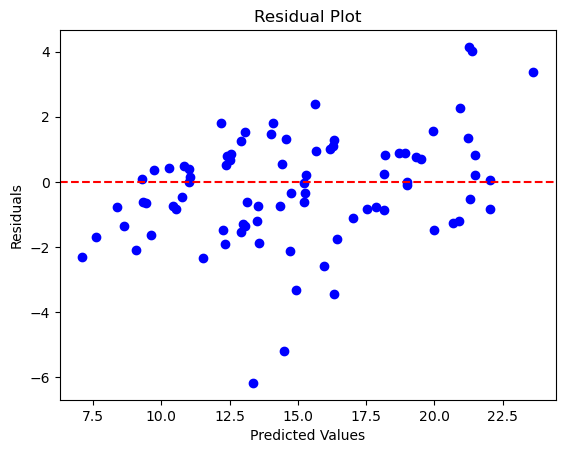

In [ ]:
'''
I wanted to see a visual representation of what the data looks like:

Residual Plot: This code creates a scatter plot showing the residuals (errors) of the model.
It compares the predicted values with the actual values, helping to identify any patterns in
the model's errors, where a random spread of points around zero suggests a good fit.
'''
import matplotlib.pyplot as plt

# Get the residuals (actual - predicted)
residuals = predictions.select("label", "prediction") \
    .rdd.map(lambda row: row['label'] - row['prediction']).collect()

# Get predicted values
predicted_values = predictions.select("prediction").rdd.map(lambda row: row['prediction']).collect()

# Create the residual plot
plt.scatter(predicted_values, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')  # line at 0 to show residuals distribution
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


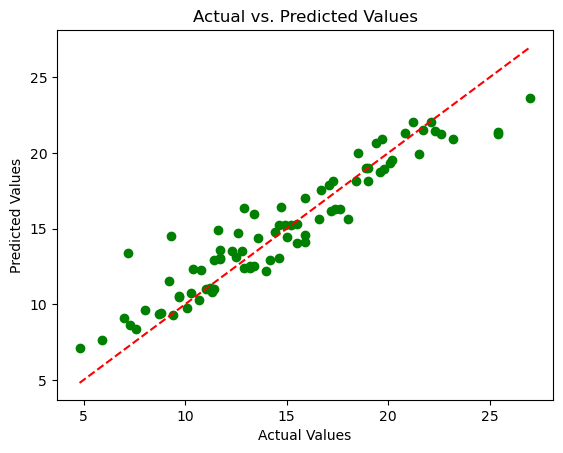

In [ ]:
# Get actual values
'''
Actual vs. Predicted Scatter Plot: This code plots the actual values against the predicted values
to visualize how well the model's predictions match the true values. A perfect
fit would show the points along
the diagonal line (y = x).
'''
actual_values = predictions.select("label").rdd.map(lambda row: row['label']).collect()

# Create the scatter plot
plt.scatter(actual_values, predicted_values, color='green')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

'''
In the Actual vs. Predicted scatter plot, the points that fall on the line (y = x) indicate perfect
predictions, where the model's predicted values exactly match the actual values.

Here’s what it means for points on the line:

- The model's predictions are accurate for those data points, meaning the prediction error
(residual) is zero.
- These points demonstrate that the model has correctly captured the underlying pattern for
these specific instances.
- If a large number of points are close to or on the line, it suggests the model is performing well.

In contrast, points away from the line indicate prediction errors, where the model's predictions
differ from the actual values, showing where the model could improve.
'''



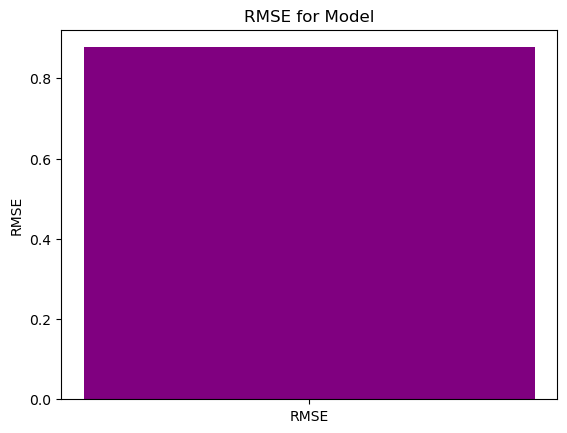

In [ ]:
# RMSE value from previous evaluation
#3. RMSE Bar Plot:
'''
A bar plot can work for visualizing a single evaluation metric like RMSE. It would display
the RMSE value as a purple bar, helping you understand how the model's error behaves. However,
it’s more useful for comparing multiple metrics or models. For just one RMSE value, it provides
a simple, clear visual representation.
'''

rmse = evaluator.evaluate(predictions)

# Plot RMSE as a bar chart
plt.bar(['RMSE'], [rmse], color='purple')
plt.ylabel('RMSE')
plt.title('RMSE for Model')
plt.show()
